In [1]:
import numpy as np

import random
import h5py
from keras import backend as K
from nn_util import *
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.initializers import *
from keras.models import load_model
from keras.losses import *
import scipy.io.wavfile as sciwav
import multiprocessing
from sklearn.cluster import KMeans, MiniBatchKMeans

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
# external custom code I wrote
from load_data import *
from windowing import *
from pesq import *
from consts import *
from nn_blocks import *
from nn_experimental import *
from perceptual_loss import *
from evaluation import *

In [4]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [5]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

(101750, 512, 1)
3.81413e-06
0.103483
-1.0
1.0


In [6]:
input_dim = (WINDOW_SIZE, 1)

In [7]:
# softmax hardness variable
tau = K.variable(0.0001, name = "hardness")

In [8]:
DOWNSAMPLE_FACTOR = 2
CHANNEL_SIZE = WINDOW_SIZE / DOWNSAMPLE_FACTOR

# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):   
    # - - - - - - - - - - - - - - - - - - - - -
    # parameters
    # - - - - - - - - - - - - - - - - - - - - -   
    NCHAN = 32
    FILT_SIZE = 9

    # - - - - - - - - - - - - - - - - - - - - -
    # encoder
    # - - - - - - - - - - - - - - - - - - - - -
    enc_input = Input(shape = dim)
    enc = enc_input
    
    enc = Reshape(dim, input_shape = dim)(enc)  
    
    enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 2)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 4)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 8)(enc)
    enc = downsample_block(NCHAN, FILT_SIZE)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 2)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 4)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 8)(enc)
    enc = channel_change_block(1, FILT_SIZE)(enc)
    
    # quantization
    enc = Reshape((CHANNEL_SIZE,))(enc)
    pre_quant = Model(inputs = enc_input, outputs = enc)
    #enc = BlockTransformQuantization()(enc)
    enc = SoftmaxQuantization()(enc)
    
    enc = Model(inputs = enc_input, outputs = enc)
    
    # - - - - - - - - - - - - - - - - - - - - -
    # decoder
    # - - - - - - - - - - - - - - - - - - - - -
    dec_input = Input(shape = (CHANNEL_SIZE, NBINS))
    dec = dec_input
    
    # dequantization
    #dec = BlockTransformDequantization()(dec)
    dec = SoftmaxDequantization()(dec)  
    post_dequant = Model(inputs = dec_input, outputs = dec)
    dec = Reshape((CHANNEL_SIZE, 1))(dec)
    
    dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 8)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 4)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 2)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = upsample_block(NCHAN, FILT_SIZE)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 8)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 4)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 2)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = channel_change_block(1, FILT_SIZE)(dec)

    dec = Model(inputs = dec_input, outputs = dec)
    
    # return both encoder and decoder
    return enc, dec, pre_quant, post_dequant

In [9]:
# we can compute the entropy of a batch directly
def code_entropy(placeholder, code):
    all_onehots = K.reshape(code, (-1, NBINS))
    onehot_hist = K.sum(all_onehots, axis = 0)
    onehot_hist /= K.sum(onehot_hist)

    entropy = -K.sum(onehot_hist * K.log(onehot_hist + K.epsilon()) / K.log(2.0))
    loss = tau * entropy
    return K.switch(QUANTIZATION_ON, loss, K.zeros_like(loss))

def code_sparsity(placeholder, code):
    sparsity = K.mean(K.sum(K.sqrt(code + K.epsilon()), axis = -1), axis = -1) - 1.0
    #return sparsity
    return K.switch(QUANTIZATION_ON, sparsity, K.zeros_like(sparsity))

In [10]:
# map for load_model
KERAS_LOAD_MAP = {'PhaseShiftUp1D' : PhaseShiftUp1D,
                  'code_entropy' : code_entropy,
                  'code_sparsity' : code_sparsity,
                  'rmse' : rmse,
                  'ChannelResize1D' : ChannelResize1D,
                  'LinearUpSampling1D' : LinearUpSampling1D,
                  'SoftmaxQuantization' : SoftmaxQuantization,
                  'SoftmaxDequantization' : SoftmaxDequantization,
                  'BlockTransformQuantization' : BlockTransformQuantization,
                  'BlockTransformDequantization' : BlockTransformDequantization,
                  'DFT_REAL' : DFT_REAL,
                  'DFT_IMAG' : DFT_IMAG,
                  'MEL_FILTERBANKS' : MEL_FILTERBANKS,
                  'keras_dft_mag' : keras_dft_mag,
                  'keras_dct' : keras_dct,
                  'perceptual_transform' : perceptual_transform,
                  'perceptual_distance' : perceptual_distance}

In [11]:
# construct autoencoder
ac_input = Input(shape = input_dim)

encoder, decoder, pre_quant, post_dequant = autoencoder_structure(input_dim)
ac_reconstructed = decoder(encoder(ac_input))
autoencoder = Model(inputs = [ac_input], outputs = [ac_reconstructed])

In [12]:
# model parameters
loss_weights = [30.0, 5.0, 5.0, 1.0]
loss_functions = [rmse, perceptual_distance, code_sparsity, code_entropy]
n_recons = 2
n_code = 2
n_error = 0
assert(n_recons + n_code + n_error == len(loss_weights))
assert(len(loss_weights) == len(loss_functions))

In [13]:
# model specification
model_input = Input(shape = input_dim)
model_embedding = encoder(model_input)
model_pre_quant = pre_quant(model_input)
model_reconstructed = decoder(model_embedding)
model_post_dequant = post_dequant(model_embedding)
rmse_lambda = Lambda(lambda x : rmse(x[0], x[1]),
                     output_shape = lambda s : s[0])
model_quant_error = rmse_lambda([model_pre_quant, model_post_dequant])

model = Model(inputs = [model_input], outputs = [model_reconstructed] * n_recons + \
                                            [model_embedding] * n_code + \
                                            [model_quant_error] * n_error)

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1511: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_4_1/add_22/add:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_4_1/add_22/add:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_2_1/softmax_quantization_1/cond/Merge:0' shape=(?, 256, 32) dtype=float32>, <tf.Tensor 'model_2_1/softmax_quantization_1/cond/Merge:0' shape=(?, 256, 32) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [14]:
model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = Adam())

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_2 (Model)              (None, 256, 32)           182576.0  
_________________________________________________________________
model_4 (Model)              (None, 512, 1)            224719    
Total params: 407,295
Trainable params: 407,295
Non-trainable params: 0
_________________________________________________________________


In [15]:
# get untrained baseline for model
test_model_on_wav("./SA1.wav", "./train_output/SA1_uninit", autoencoder)

MSE:         155034.0
Avg err:     210.479
PESQ:        1.03861868382


[155033.78, 210.47922, 1.0386186838150024]

In [16]:
# saves current model
def save_model(prefix = 'best'):
    os.system('rm ./' + prefix + '_model.h5')
    os.system('rm ./' + prefix + '_auto.h5')
    #os.system('rm ./' + prefix + '_quant_bins.npy')
    
    model.save('./' + prefix + '_model.h5')
    autoencoder.save('./' + prefix + '_auto.h5')
    #np.save('./' + prefix + '_quant_bins.npy', K.eval(QUANT_BINS))
    
    f = h5py.File('./' + prefix + '_model.h5', 'r+')
    del f['optimizer_weights']
    f.close()

In [17]:
def evaluate_training(autoencoder, lead = ""):
    def set_evaluation(windows, wparams, eval_idxs):
        before_after_pairs = np.array([run_model_on_windows(windows[i],
                                                    wparams[i],
                                                    autoencoder,
                                                    argmax = True)
                                       for i in eval_idxs])
        
        NUM_THREADS = 8
        list_range = np.arange(0, len(eval_idxs))
        slices = [list_range[i:None:NUM_THREADS]
                  for i in xrange(0, NUM_THREADS)]
        
        def thread_func(pairs, q):
            for p in pairs:
                q.put(evaluation_metrics(p[0], p[1]))
                
        q = multiprocessing.Queue()
        threads = [multiprocessing.Process(target = thread_func,
                                           args = (before_after_pairs[slices[i]], q))
                   for i in xrange(0, NUM_THREADS)]
        [t.start() for t in threads]
        [t.join() for t in threads]
        
        return np.array([q.get() for i in list_range])
    
    train_eval_idxs = random.sample(range(0, len(train_windows)), TRAIN_EVALUATE)
    val_eval_idxs = random.sample(range(0, len(val_windows)), VAL_EVALUATE)
    
    print lead + "Format: [MSE, avg err, PESQ]"
    
    # train set evaluation
    train_metrics = set_evaluation(train_windows, train_wparams,
                                   train_eval_idxs)
    print lead + "    Train: (mean)", np.mean(train_metrics, axis = 0)
    print lead + "    Train: (max) ", np.max(train_metrics, axis = 0)
    print lead + "    Train: (min) ", np.min(train_metrics, axis = 0)
    
    # validation set evaluation
    val_metrics = set_evaluation(val_windows, val_wparams,
                                 val_eval_idxs)
    print lead + "    Val:   (mean)", np.mean(val_metrics, axis = 0)
    print lead + "    Val:   (max) ", np.max(val_metrics, axis = 0)
    print lead + "    Val:   (min) ", np.min(val_metrics, axis = 0)
    
    # returns mean PESQ on validation
    return np.mean(val_metrics, axis = 0)[2]

In [18]:
X_train = np.copy(train_processed)
ntrain = X_train.shape[0]

BATCH_SIZE = 128
NUM_EPOCHS = 300
EPOCHS_BEFORE_QUANT_ON = 5
EPOCHS_BEFORE_TAU = 20

ORIG_BITRATE = 256.00
TARGET_BITRATE = 16.00
PRE_ENTROPY_RATE = ORIG_BITRATE / DOWNSAMPLE_FACTOR

TARGET_ENTROPY = (TARGET_BITRATE / PRE_ENTROPY_RATE * 16.0)
TARGET_ENTROPY *= (STEP_SIZE / float(WINDOW_SIZE))
TARGET_ENTROPY_FUZZ = 0.1

TAU_CHANGE_RATE = 0.0125
MIN_TAU = 0.5

NUM_QUANT_VECS = 5000

STARTING_LR = 0.0005
ENDING_LR = 0.0001

print "Target entropy:", TARGET_ENTROPY

Target entropy: 1.875


In [19]:
best_val_pesq = 0.0
K.set_value(tau, 0.0)
T_i = 0.0

In [20]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})
lead = "    "

for epoch in range(1, NUM_EPOCHS + 1):
    print "Epoch " + str(epoch) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    num_batches = len(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        # cosine annealing for model's learning rate
        train_pct = T_i / float(NUM_EPOCHS)
        opt_lr = ENDING_LR + 0.5 * (STARTING_LR - ENDING_LR) * (1 + math.cos(3.14159 * train_pct))
        T_i += (1.0 / num_batches)
        K.set_value(model.optimizer.lr, opt_lr)
        
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
               
        # train autoencoder
        a_y = [batch] * n_recons + \
              [np.zeros((nbatch, 1, 1))] * n_code + \
              [np.zeros((nbatch, 1))] * n_error

        a_losses = model.train_on_batch(batch, a_y)
        
        # print statistics every 10 batches so we know what's going on
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for w in xrange(0, len(loss_weights)):
                    loss_arr[w + 1] *= loss_weights[w]
                print loss_arr,
            
            print K.get_value(tau), opt_lr,
        
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    # estimate code entropy from random samples (if quantization is on)
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) > 0):
        NUM = 500
        rows = np.random.randint(X_train.shape[0], size = NUM)
        code = encoder.predict(X_train[rows, :], verbose = 0)
        probs = np.reshape(code, (code.shape[0] * code.shape[1], NBINS))
        hist = np.sum(probs, axis = 0)
        hist /= np.sum(hist)

        entropy = 0
        for i in hist:
            if (i < 1e-4): continue
            entropy += i * math.log(i, 2)
        entropy = -entropy

        print lead + "----------------"
        print lead + "Code entropy:", entropy

        # ---------------------------------------------------------
        # handle updating entropy weight (tau)
        # ---------------------------------------------------------
        if (epoch >= EPOCHS_BEFORE_TAU):
            old_tau = K.get_value(tau)

            if (entropy < TARGET_ENTROPY - TARGET_ENTROPY_FUZZ):
                new_tau = old_tau - TAU_CHANGE_RATE
                if (new_tau <= MIN_TAU):
                    new_tau = MIN_TAU

                K.set_value(tau, new_tau)
                print lead + "Updated tau from", old_tau, "to", new_tau
            elif (entropy > TARGET_ENTROPY + TARGET_ENTROPY_FUZZ):
                new_tau = old_tau + TAU_CHANGE_RATE

                K.set_value(tau, new_tau)
                print lead + "Updated tau from", old_tau, "to", new_tau
            else:
                print lead + "Tau stays at", old_tau
    
    # ---------------------------------------------------------
    # evaluate autoencoder on training/validation data evey epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    print lead + "Evaluating autoencoder..."
    
    
    metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                              autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SA1:         ", metrics
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SA1 (arg):   ", metrics
    
    metrics_tst = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SX383:       ", metrics_tst
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SX383 (arg): ", metrics
    
    if (K.get_value(QUANTIZATION_ON) > 0):
        val_pesq = evaluate_training(autoencoder, lead)
        if (val_pesq > best_val_pesq and entropy <= TARGET_ENTROPY):
            print lead + "NEW best model! Validation mean-PESQ", val_pesq

            print lead + "Saving model..."
            save_model()
            best_val_pesq = val_pesq
            patience_epoch = epoch
        else:
            print lead + "Best validation mean-PESQ seen:", best_val_pesq
    
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    # turn quantization on after a certain # of epochs
    # ---------------------------------------------------------
    if (epoch == EPOCHS_BEFORE_QUANT_ON):
        print lead + "----------------"
        print lead + "Turning quantization on!"
        
        random_windows = []
        for i in xrange(0, NUM_QUANT_VECS):
            w_idx = random.randint(0, train_processed.shape[0] - 1)
            random_windows.append(train_processed[w_idx])

        random_windows = np.array(random_windows)
        print lead + "    Selecting random code vectors for analysis..."
        encoded_windows = encoder.predict(random_windows, batch_size = 128, verbose = 0)
        encoded_windows = encoded_windows[:, :, 0]
        encoded_windows = np.reshape(encoded_windows, (-1, 1))

        print lead + "    K means clustering for bins initialization..."
        km = MiniBatchKMeans(n_clusters = NBINS).fit(encoded_windows)
        K.set_value(QUANT_BINS, km.cluster_centers_.flatten())

        K.set_value(QUANTIZATION_ON, True)
        
        cluster_score = np.sqrt(np.median(np.min(km.transform(encoded_windows), axis = 1)))
        print lead + "    Done. Cluster score:", cluster_score
        
        K.set_value(tau, MIN_TAU)

Epoch 1:
    101120:  [3.050299 0.012373 0.535821 0.000000 0.000000] [3.050299 0.371194 2.679105 0.000000 0.000000] 0.0 0.0004999891713955                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
    Total time for epoch: 73.2660439014s
    ----------------
    Evaluating autoencoder...
    SA1:          [2888.1331, 28.683292, 3.655837059020996]
    SX

    101120:  [4.641281 0.010291 0.547336 0.066274 1.264492] [4.641281 0.308740 2.736679 0.331371 1.264492] 0.5 0.000499463860633                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 68.9322750568s
    ----------------
    Code entropy: 2.50313185234
    ----------------
    Evaluating autoencoder...
    SA1:          [5528.3789

    101120:  [4.263475 0.010419 0.490626 0.047736 1.259097] [4.263475 0.312567 2.453130 0.238681 1.259097] 0.5 0.000498424593417                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    Total time for epoch: 69.1689610481s
    ----------------
    Code entropy: 2.49124279321
    ----------------
    Evaluating autoencoder...
    SA1:          [4137.3

    101120:  [4.139174 0.010058 0.479919 0.040435 1.235679] [4.139174 0.301726 2.399595 0.202175 1.235679] 0.5 0.000496841459101                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    Total time for epoch: 68.8618118763s
    ----------------
    Code entropy: 2.433204728
    ----------------
    Evaluating autoencoder...
    SA1:          [4206.577

        Val:   (mean) [8950.452530 46.428353 3.921921]
        Val:   (max)  [76241.171875 106.215919 4.372300]
        Val:   (min)  [368.706543 10.840888 2.654533]
    Best validation mean-PESQ seen: 0.0
    Total time for evaluation: 12.8772890568s
Epoch 22:
    101120:  [4.068358 0.011178 0.461738 0.037306 1.237784] [4.068358 0.335354 2.308689 0.186532 1.237784] 0.525 0.00049471879694                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

    SA1 (arg):    [4554.499, 42.34779, 3.1771533489227295]
    SX383:        [4238.6577, 32.182053, 3.3608860969543457]
    SX383 (arg):  [4338.7773, 33.013943, 3.2730789184570312]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [10878.806742 51.091908 3.633124]
        Train: (max)  [121156.750000 191.355240 4.238145]
        Train: (min)  [606.670410 16.421906 2.824792]
        Val:   (mean) [10414.220765 50.456197 3.879322]
        Val:   (max)  [79387.054688 114.015350 4.311863]
        Val:   (min)  [430.948669 11.647467 2.594495]
    Best validation mean-PESQ seen: 0.0
    Total time for evaluation: 12.7782008648s
Epoch 27:
    101120:  [4.186221 0.010211 0.463922 0.034937 1.385592] [4.186221 0.306331 2.319612 0.174686 1.385592] 0.5875 0.000492062424992                                                                                                                                                                                                                                

    101120:  [4.257354 0.012799 0.450781 0.033136 1.453787] [4.257354 0.383982 2.253907 0.165678 1.453787] 0.6375 0.000489557900502                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 68.4105660915s
    ----------------
    Code entropy: 2.18438190477
    Updated tau from 0.6375 to 0.64999986887
    ----------------
    Evalua

        Train: (mean) [9507.680172 50.817256 3.647363]
        Train: (max)  [56009.425781 129.142776 4.220075]
        Train: (min)  [1232.139160 21.359543 2.466632]
        Val:   (mean) [11266.150289 53.494592 3.835649]
        Val:   (max)  [85825.570312 121.468987 4.289908]
        Val:   (min)  [488.503113 12.539071 3.154432]
    Best validation mean-PESQ seen: 0.0
    Total time for evaluation: 12.9694161415s
Epoch 36:
    101120:  [4.413218 0.010421 0.506953 0.028466 1.423493] [4.413218 0.312626 2.534767 0.142331 1.423493] 0.7 0.000485960169256                                                                                                                                                                                                                                                                                                                                                                                                                                                          

    101120:  [4.426315 0.012151 0.475746 0.028694 1.539595] [4.426315 0.364518 2.378730 0.143472 1.539595] 0.75 0.000482714477561                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
    Total time for epoch: 69.2453770638s
    ----------------
    Code entropy: 2.00710950541
    Updated tau from 0.75 to 0.762499761581
    ----------------
    

        Train: (mean) [11243.204586 55.228086 3.528101]
        Train: (max)  [84583.078125 130.598801 4.230973]
        Train: (min)  [1036.630249 20.930828 2.399431]
        Val:   (mean) [11395.855547 54.943022 3.760117]
        Val:   (max)  [77369.062500 121.848465 4.230485]
        Val:   (min)  [480.699036 12.505185 2.379110]
    Best validation mean-PESQ seen: 3.69979470968
    Total time for evaluation: 12.4064362049s
Epoch 45:
    101120:  [4.446495 0.011878 0.501703 0.026109 1.451106] [4.446495 0.356331 2.508516 0.130543 1.451106] 0.775 0.00047820732068                                                                                                                                                                                                                                                                                                                                                                                                                                              

    101120:  [4.418403 0.012882 0.482150 0.025938 1.491505] [4.418403 0.386461 2.410748 0.129689 1.491505] 0.7875 0.000474249270719                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 68.9106838703s
    ----------------
    Code entropy: 1.88810957037
    Tau stays at 0.7875
    ----------------
    Evaluating autoencoder...
 

        Train: (mean) [12839.812571 59.184409 3.487651]
        Train: (max)  [123488.281250 148.494339 4.082188]
        Train: (min)  [1346.945923 20.140570 2.624529]
        Val:   (mean) [12185.246172 57.179092 3.643295]
        Val:   (max)  [83456.867188 127.370102 4.190506]
        Val:   (min)  [533.034668 13.315358 2.472798]
    Best validation mean-PESQ seen: 3.79409009218
    Total time for evaluation: 12.545361042s
Epoch 54:
    101120:  [4.332929 0.010985 0.509828 0.024103 1.333717] [4.332929 0.329554 2.549141 0.120517 1.333717] 0.775 0.000468872693979                                                                                                                                                                                                                                                                                                                                                                                                                                             

    101120:  [4.396877 0.014659 0.468993 0.024795 1.488180] [4.396877 0.439758 2.344966 0.123973 1.488180] 0.775 0.000464237417625                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
    Total time for epoch: 68.8993251324s
    ----------------
    Code entropy: 1.85922073713
    Tau stays at 0.775
    ----------------
    Evaluating autoencode

        Val:   (mean) [13946.981747 60.370407 3.782305]
        Val:   (max)  [90639.554688 136.303864 4.243558]
        Val:   (min)  [569.943604 13.446569 2.516461]
    Best validation mean-PESQ seen: 3.80253635645
    Total time for evaluation: 12.3375339508s
Epoch 63:
    101120:  [4.408345 0.012851 0.516268 0.023734 1.322800] [4.408345 0.385537 2.581339 0.118669 1.322800] 0.7625 0.000458039143822                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

    SA1 (arg):    [5498.397, 47.309944, 3.229283571243286]
    SX383:        [4581.0688, 35.866688, 3.2965805530548096]
    SX383 (arg):  [4678.0503, 36.506893, 3.226918935775757]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [10962.775656 55.746298 3.652078]
        Train: (max)  [61471.593750 142.467255 4.193804]
        Train: (min)  [1437.653564 22.044575 2.884249]
        Val:   (mean) [12053.344832 56.283107 3.784472]
        Val:   (max)  [81198.710938 126.309555 4.262110]
        Val:   (min)  [509.040588 12.900829 2.496964]
    Best validation mean-PESQ seen: 3.81508869648
    Total time for evaluation: 12.9327728748s
Epoch 68:
    101120:  [4.324184 0.012168 0.490169 0.024628 1.385164] [4.324184 0.365032 2.450846 0.123142 1.385164] 0.75 0.000451407696442                                                                                                                                                                                                                         

    101120:  [4.349250 0.012264 0.501376 0.024162 1.353646] [4.349250 0.367914 2.506880 0.120810 1.353646] 0.7375 0.000445802829404                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 68.8601858616s
    ----------------
    Code entropy: 1.80932733558
    Tau stays at 0.7375
    ----------------
    Evaluating autoencoder...
 

        Train: (mean) [13023.971178 58.669664 3.561362]
        Train: (max)  [89035.296875 137.064117 4.207158]
        Train: (min)  [1581.679199 22.204157 2.039414]
        Val:   (mean) [11824.670032 55.931873 3.788062]
        Val:   (max)  [77002.062500 122.929863 4.240512]
        Val:   (min)  [514.270020 12.907382 3.246922]
    Best validation mean-PESQ seen: 3.83762051582
    Total time for evaluation: 12.8222169876s
Epoch 77:
    101120:  [4.447613 0.011454 0.546893 0.022609 1.256494] [4.447613 0.343607 2.734467 0.113045 1.256494] 0.725 0.000438438240016                                                                                                                                                                                                                                                                                                                                                                                                                                             

    SA1 (arg):    [5189.7705, 45.639946, 3.3270180225372314]
    SX383:        [4569.4609, 35.1553, 3.3538777828216553]
    SX383 (arg):  [4650.8486, 35.598549, 3.299497365951538]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [10401.887518 53.971796 3.686247]
        Train: (max)  [62691.601562 135.250641 4.253165]
        Train: (min)  [1330.615845 19.902796 2.028360]
        Val:   (mean) [12058.361833 56.029056 3.870733]
        Val:   (max)  [84958.476562 124.279404 4.266531]
        Val:   (min)  [517.080505 12.921273 2.605487]
    Best validation mean-PESQ seen: 3.85860108137
    Total time for evaluation: 13.4188539982s
Epoch 82:
    101120:  [4.188622 0.010501 0.494193 0.022497 1.290129] [4.188622 0.315041 2.470967 0.112484 1.290129] 0.725 0.000430694201675                                                                                                                                                                                                                        

    101120:  [4.128902 0.010441 0.472641 0.023455 1.335197] [4.128902 0.313225 2.363204 0.117275 1.335197] 0.725 0.000424239998044                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 69.0141830444s
    ----------------
    Code entropy: 1.88083104073
    Tau stays at 0.725
    ----------------
    Evaluating autoencoder...
   

        Val:   (mean) [11807.175695 55.265129 3.824591]
        Val:   (max)  [75350.390625 122.820854 4.299444]
        Val:   (min)  [515.604065 12.802448 2.034626]
    Best validation mean-PESQ seen: 3.86311839104
    Total time for evaluation: 12.6959939003s
Epoch 91:
    101120:  [4.280201 0.013390 0.483559 0.022693 1.347240] [4.280201 0.401703 2.417795 0.113463 1.347240] 0.725 0.00041586710253                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

    SA1 (arg):    [5423.8589, 46.427811, 3.340585231781006]
    SX383:        [4637.3467, 35.00576, 3.4964332580566406]
    SX383 (arg):  [4724.1494, 35.605118, 3.4148268699645996]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [12271.506523 58.596928 3.691975]
        Train: (max)  [55746.683594 134.845490 4.247249]
        Train: (min)  [1500.269165 22.884680 2.489868]
        Val:   (mean) [12046.979199 55.653368 3.902024]
        Val:   (max)  [77971.828125 126.473137 4.296315]
        Val:   (min)  [518.480103 12.937486 2.574856]
    NEW best model! Validation mean-PESQ 3.90202388287
    Saving model...
    Total time for evaluation: 12.9442601204s
Epoch 96:
    101120:  [4.138686 0.013280 0.450258 0.023089 1.373539] [4.138686 0.398411 2.251290 0.115445 1.373539] 0.725 0.000407176623877                                                                                                                                                                                              

    101120:  [4.214960 0.011913 0.473319 0.022473 1.378601] [4.214960 0.357398 2.366596 0.112364 1.378601] 0.725 0.000400011560516                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 69.0324869156s
    ----------------
    Code entropy: 1.92817959734
    Tau stays at 0.725
    ----------------
    Evaluating autoencoder...
   

        Val:   (mean) [11950.075607 56.057504 3.815889]
        Val:   (max)  [73258.960938 125.915642 4.284055]
        Val:   (min)  [535.825989 13.034095 2.223486]
    Best validation mean-PESQ seen: 3.90202388287
    Total time for evaluation: 12.8129332066s
Epoch 105:
    101120:  [4.190378 0.011578 0.471478 0.022294 1.374170] [4.190378 0.347346 2.357392 0.111470 1.374170] 0.725 0.000390810001843                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

    SA1 (arg):    [5672.8774, 47.802799, 3.28899884223938]
    SX383:        [4611.7842, 35.816181, 3.491048812866211]
    SX383 (arg):  [4708.0718, 36.401405, 3.4348647594451904]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [12234.740311 56.662755 3.738282]
        Train: (max)  [133746.250000 209.133347 4.266690]
        Train: (min)  [1264.335327 21.363169 2.501751]
        Val:   (mean) [12025.707320 56.870260 3.863373]
        Val:   (max)  [75873.820312 128.461731 4.362312]
        Val:   (min)  [522.168823 13.115034 2.428110]
    Best validation mean-PESQ seen: 3.90202388287
    Total time for evaluation: 12.6301338673s
Epoch 110:
    101120:  [4.075950 0.012457 0.432258 0.022412 1.428891] [4.075950 0.373708 2.161291 0.112060 1.428891] 0.725 0.000381359539687                                                                                                                                                                                                                      

    101120:  [3.997992 0.010375 0.457614 0.020803 1.294647] [3.997992 0.311257 2.288072 0.104016 1.294647] 0.725 0.000373637345164                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 68.9325928688s
    ----------------
    Code entropy: 1.85242570591
    Tau stays at 0.725
    ----------------
    Evaluating autoencoder...
   

        Train: (mean) [12315.056449 58.689597 3.665550]
        Train: (max)  [119946.867188 200.754120 4.407306]
        Train: (min)  [1353.233765 20.300478 2.765005]
        Val:   (mean) [11306.675534 55.086568 3.848373]
        Val:   (max)  [72168.929688 122.883377 4.312847]
        Val:   (min)  [498.604034 12.922400 2.476916]
    Best validation mean-PESQ seen: 3.93644164085
    Total time for evaluation: 12.5473299026s
Epoch 119:
    101120:  [4.132563 0.012709 0.469729 0.020863 1.298320] [4.132563 0.381283 2.348646 0.104313 1.298320] 0.7125 0.000363804545515                                                                                                                                                                                                                                                                                                                                                                                                                                          

    SA1 (arg):    [5148.4302, 45.822269, 3.2911996841430664]
    SX383:        [4192.3369, 34.087749, 3.389744758605957]
    SX383 (arg):  [4282.7007, 34.730072, 3.330643653869629]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [13714.290911 59.146883 3.671433]
        Train: (max)  [83483.250000 133.520416 4.232297]
        Train: (min)  [1060.950317 20.852316 2.001658]
        Val:   (mean) [11630.084841 55.204720 3.877560]
        Val:   (max)  [77609.523438 123.983559 4.308234]
        Val:   (min)  [517.020935 12.849677 2.495879]
    Best validation mean-PESQ seen: 3.93644164085
    Total time for evaluation: 12.6241290569s
Epoch 124:
    101120:  [4.006496 0.011794 0.454670 0.021441 1.272117] [4.006496 0.353828 2.273348 0.107204 1.272117] 0.7 0.000353796862337                                                                                                                                                                                                                        

    101120:  [4.134824 0.011871 0.480939 0.020939 1.269310] [4.134824 0.356121 2.404696 0.104697 1.269310] 0.7 0.000345683218635                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 68.7559430599s
    ----------------
    Code entropy: 1.82923072812
    Tau stays at 0.7
    ----------------
    Evaluating autoencoder...
    SA1

        Val:   (mean) [10853.794801 54.086659 3.933098]
        Val:   (max)  [74248.523438 121.127495 4.375021]
        Val:   (min)  [482.515228 12.779520 2.775694]
    Best validation mean-PESQ seen: 3.93644164085
    Total time for evaluation: 12.6783769131s
Epoch 133:
    101120:  [3.960813 0.012174 0.423628 0.021102 1.371927] [3.960813 0.365234 2.118140 0.105511 1.371927] 0.7 0.000335430143656                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

    SA1 (arg):    [4547.7104, 42.560299, 3.457134962081909]
    SX383:        [3829.9863, 32.274605, 3.5561563968658447]
    SX383 (arg):  [3878.6274, 32.66222, 3.515815496444702]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [10500.478337 53.371631 3.810841]
        Train: (max)  [52656.484375 123.546623 4.286462]
        Train: (min)  [1228.197998 19.579704 3.004734]
        Val:   (mean) [10140.239773 51.131318 3.924563]
        Val:   (max)  [73795.007812 114.448311 4.369613]
        Val:   (min)  [472.217743 12.294211 2.633501]
    Best validation mean-PESQ seen: 3.93644164085
    Total time for evaluation: 13.0820949078s
Epoch 138:
    101120:  [4.019492 0.011484 0.457063 0.020571 1.286812] [4.019492 0.344512 2.285314 0.102854 1.286812] 0.6875 0.000325079957279                                                                                                                                                                                                                      

    101120:  [4.036485 0.012582 0.448849 0.020598 1.311780] [4.036485 0.377466 2.244246 0.102992 1.311780] 0.6875 0.000316748945042                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 69.5377960205s
    ----------------
    Code entropy: 1.87561915189
    Tau stays at 0.6875
    ----------------
    Evaluating autoencoder...
 

        Val:   (mean) [11676.861819 54.643727 3.883305]
        Val:   (max)  [83241.328125 123.387108 4.292399]
        Val:   (min)  [501.252869 12.521104 2.135135]
    Best validation mean-PESQ seen: 3.93644164085
    Total time for evaluation: 12.6756060123s
Epoch 147:
    101120:  [3.875297 0.009940 0.452251 0.020466 1.213501] [3.875297 0.298208 2.261257 0.102331 1.213501] 0.6875 0.00030629557751                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

    SA1 (arg):    [4336.9146, 41.489315, 3.493685007095337]
    SX383:        [3883.1912, 31.553106, 3.5192408561706543]
    SX383 (arg):  [3938.9614, 31.999741, 3.494985818862915]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [10552.426945 52.627147 3.772786]
        Train: (max)  [107613.546875 188.740570 4.316404]
        Train: (min)  [1520.619019 23.186203 2.953682]
        Val:   (mean) [10216.383777 50.773891 3.942176]
        Val:   (max)  [75155.562500 112.358818 4.341078]
        Val:   (min)  [475.164337 12.172986 2.218396]
    Best validation mean-PESQ seen: 3.93644164085
    Total time for evaluation: 13.001183033s
Epoch 152:
    101120:  [3.963042 0.011962 0.438083 0.020880 1.309380] [3.963042 0.358849 2.190414 0.104398 1.309380] 0.6875 0.000295824954267                                                                                                                                                                                                                     

    101120:  [3.949053 0.011815 0.421149 0.020950 1.384115] [3.949053 0.354440 2.105747 0.104751 1.384115] 0.6875 0.000287455317843                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 69.5060780048s
    ----------------
    Code entropy: 1.99571629103
    Updated tau from 0.6875 to 0.699999821186
    ----------------
    Evalu

        Train: (mean) [10602.336157 54.941995 3.852143]
        Train: (max)  [41969.101562 113.793373 4.301424]
        Train: (min)  [1379.125244 20.768095 2.756611]
        Val:   (mean) [10619.649963 51.885049 4.005194]
        Val:   (max)  [68737.835938 116.133026 4.368172]
        Val:   (min)  [490.792358 12.221357 2.646039]
    Best validation mean-PESQ seen: 3.97407216072
    Total time for evaluation: 12.5271759033s
Epoch 161:
    101120:  [3.884648 0.011856 0.421587 0.019772 1.322171] [3.884648 0.355679 2.107937 0.098861 1.322171] 0.7 0.000277025937873                                                                                                                                                                                                                                                                                                                                                                                                                                              

    SA1 (arg):    [5080.5557, 45.166389, 3.3540477752685547]
    SX383:        [4285.4038, 34.250519, 3.490978956222534]
    SX383 (arg):  [4325.2173, 34.561264, 3.4434592723846436]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [9673.185524 51.795357 3.703471]
        Train: (max)  [53881.070312 113.140236 4.249449]
        Train: (min)  [1370.426270 22.770098 2.716313]
        Val:   (mean) [11318.958680 54.550967 3.857493]
        Val:   (max)  [73460.289062 120.835739 4.297519]
        Val:   (min)  [523.926575 12.934452 2.220526]
    Best validation mean-PESQ seen: 3.97620883226
    Total time for evaluation: 12.4681971073s
Epoch 166:
    101120:  [3.873964 0.010203 0.428683 0.020387 1.322532] [3.873964 0.306083 2.143416 0.101933 1.322532] 0.6875 0.000266659528104                                                                                                                                                                                                                     

    101120:  [3.935052 0.012459 0.418336 0.020730 1.365957] [3.935052 0.373765 2.091679 0.103651 1.365957] 0.6875 0.000258430840538                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 69.5227341652s
    ----------------
    Code entropy: 1.89259174046
    Tau stays at 0.6875
    ----------------
    Evaluating autoencoder...
 

        Val:   (mean) [11887.197035 56.060079 3.859273]
        Val:   (max)  [76376.679688 125.362953 4.273974]
        Val:   (min)  [540.554688 13.125441 2.061228]
    Best validation mean-PESQ seen: 3.97620883226
    Total time for evaluation: 12.3199460506s
Epoch 175:
    101120:  [3.934798 0.012801 0.436687 0.019940 1.267641] [3.934798 0.384021 2.183435 0.099700 1.267641] 0.675 0.000248249213583                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

    SA1 (arg):    [4868.7227, 44.073017, 3.4526591300964355]
    SX383:        [4211.5068, 33.48217, 3.539729118347168]
    SX383 (arg):  [4252.98, 33.847755, 3.4729526042938232]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [11655.529099 54.628383 3.789132]
        Train: (max)  [76095.515625 137.617981 4.308015]
        Train: (min)  [1005.102661 20.540234 2.071833]
        Val:   (mean) [11297.565555 53.726961 3.970305]
        Val:   (max)  [81422.273438 118.504417 4.344149]
        Val:   (min)  [510.347015 12.672764 3.453746]
    Best validation mean-PESQ seen: 3.98510802984
    Total time for evaluation: 12.2804658413s
Epoch 180:
    101120:  [3.935041 0.011076 0.461349 0.019181 1.200114] [3.935041 0.332276 2.306746 0.095905 1.200114] 0.675 0.000238209431698                                                                                                                                                                                                                        

    101120:  [3.994256 0.013343 0.425060 0.020403 1.366641] [3.994256 0.400297 2.125302 0.102016 1.366641] 0.675 0.000230298241931                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 68.9369089603s
    ----------------
    Code entropy: 1.87312760224
    Tau stays at 0.675
    ----------------
    Evaluating autoencoder...
   

        Val:   (mean) [10895.814133 52.774831 3.943879]
        Val:   (max)  [72789.742188 115.916580 4.327046]
        Val:   (min)  [486.362244 12.279943 2.641148]
    Best validation mean-PESQ seen: 3.98510802984
    Total time for evaluation: 12.3509681225s
Epoch 189:
    101120:  [3.780805 0.011506 0.405668 0.019532 1.309636] [3.780805 0.345170 2.028339 0.097660 1.309636] 0.675 0.000220582817832                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

    SA1 (arg):    [4531.481, 42.068691, 3.510283946990967]
    SX383:        [3962.4395, 32.442139, 3.5218865871429443]
    SX383 (arg):  [4016.6633, 32.802921, 3.475034236907959]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [9404.705343 50.672152 3.847441]
        Train: (max)  [40491.488281 106.455070 4.391757]
        Train: (min)  [1173.924194 20.041847 3.035007]
        Val:   (mean) [10329.638693 51.173622 3.999275]
        Val:   (max)  [72583.828125 113.891556 4.353435]
        Val:   (min)  [463.546387 11.972651 2.752343]
    Best validation mean-PESQ seen: 3.98510802984
    Total time for evaluation: 12.2671990395s
Epoch 194:
    101120:  [3.748304 0.010735 0.409843 0.019120 1.281444] [3.748304 0.322048 2.049214 0.095598 1.281444] 0.675 0.000211085070342                                                                                                                                                                                                                        

    101120:  [3.832726 0.011116 0.425427 0.018859 1.277830] [3.832726 0.333465 2.127134 0.094297 1.277830] 0.675 0.000203661115308                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 68.7654850483s
    ----------------
    Code entropy: 1.85867835124
    Tau stays at 0.675
    ----------------
    Evaluating autoencoder...
   

        Val:   (mean) [10441.335976 51.449189 3.959430]
        Val:   (max)  [68401.789062 115.450531 4.355803]
        Val:   (min)  [484.841949 12.273874 2.299838]
    Best validation mean-PESQ seen: 3.98510802984
    Total time for evaluation: 12.8748559952s
Epoch 203:
    101120:  [3.805687 0.014269 0.401594 0.019295 1.273173] [3.805687 0.428068 2.007970 0.096476 1.273173] 0.675 0.000194620341383                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

    SA1 (arg):    [4494.0801, 42.304157, 3.4728033542633057]
    SX383:        [3940.7249, 32.679272, 3.597533702850342]
    SX383 (arg):  [3986.7693, 33.032284, 3.5524678230285645]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [8890.016461 47.502265 3.837199]
        Train: (max)  [72426.875000 125.811195 4.358999]
        Train: (min)  [972.771729 20.200563 2.844003]
        Val:   (mean) [10430.227191 51.935335 3.979524]
        Val:   (max)  [67121.601562 115.619415 4.336906]
        Val:   (min)  [456.187531 12.096839 3.374600]
    Best validation mean-PESQ seen: 3.98510802984
    Total time for evaluation: 12.6134130955s
Epoch 208:
    101120:  [3.790123 0.011061 0.415216 0.019113 1.286658] [3.790123 0.331820 2.076079 0.095566 1.286658] 0.675 0.000185868405289                                                                                                                                                                                                                       

    101120:  [3.670823 0.009792 0.409778 0.018387 1.236240] [3.670823 0.293757 2.048890 0.091936 1.236240] 0.675 0.000179090968155                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 68.8124880791s
    ----------------
    Code entropy: 1.81525965116
    Tau stays at 0.675
    ----------------
    Evaluating autoencoder...
   

        Val:   (mean) [10096.919040 51.047878 4.003207]
        Val:   (max)  [71700.562500 113.506882 4.343934]
        Val:   (min)  [445.538971 11.923486 2.820585]
    Best validation mean-PESQ seen: 4.00874838591
    Total time for evaluation: 12.2548651695s
Epoch 217:
    101120:  [3.816783 0.012058 0.407046 0.019771 1.320965] [3.816783 0.361735 2.035228 0.098855 1.320965] 0.675 0.000170918816901                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

    SA1 (arg):    [4420.0312, 41.754807, 3.6951351165771484]
    SX383:        [3961.4946, 32.061611, 3.619835138320923]
    SX383 (arg):  [3999.1687, 32.388321, 3.5895583629608154]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [10463.796758 51.747050 3.859026]
        Train: (max)  [55675.085938 124.330582 4.354631]
        Train: (min)  [879.934937 19.119947 2.876879]
        Val:   (mean) [10414.303311 50.775477 4.005143]
        Val:   (max)  [73728.585938 111.313484 4.373798]
        Val:   (min)  [470.030090 12.027604 2.665418]
    Best validation mean-PESQ seen: 4.00874838591
    Total time for evaluation: 12.6092801094s
Epoch 222:
    101120:  [3.718586 0.011376 0.406989 0.018831 1.248202] [3.718586 0.341285 2.034944 0.094155 1.248202] 0.675 0.00016310046766                                                                                                                                                                                                                       

    101120:  [3.737813 0.010164 0.424504 0.019468 1.213035] [3.737813 0.304920 2.122519 0.097339 1.213035] 0.675 0.000157114960297                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 68.9452011585s
    ----------------
    Code entropy: 1.82196986815
    Tau stays at 0.675
    ----------------
    Evaluating autoencoder...
   

        Val:   (mean) [10266.077249 51.422154 3.984433]
        Val:   (max)  [67747.593750 114.187050 4.372493]
        Val:   (min)  [457.951019 12.045764 2.611315]
    Best validation mean-PESQ seen: 4.01740072012
    Total time for evaluation: 12.6031520367s
Epoch 231:
    101120:  [3.743458 0.011503 0.406217 0.018889 1.272829] [3.743458 0.345097 2.031087 0.094445 1.272829] 0.675 0.000149986767654                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

    SA1 (arg):    [4638.2583, 42.113445, 3.601076602935791]
    SX383:        [3803.0713, 31.972197, 3.6223769187927246]
    SX383 (arg):  [3864.9507, 32.338856, 3.569359302520752]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [11705.618943 54.954275 3.880550]
        Train: (max)  [73143.734375 124.765953 4.354490]
        Train: (min)  [1515.118408 21.751791 2.943075]
        Val:   (mean) [10336.780789 50.995996 3.998377]
        Val:   (max)  [70707.187500 114.047562 4.352959]
        Val:   (min)  [466.995453 12.097407 2.783127]
    Best validation mean-PESQ seen: 4.02111186981
    Total time for evaluation: 12.710490942s
Epoch 236:
    101120:  [3.657468 0.010275 0.418286 0.018002 1.167778] [3.657468 0.308247 2.091431 0.090011 1.167778] 0.675 0.00014326975016                                                                                                                                                                                                                        

    101120:  [3.565556 0.010274 0.388853 0.018512 1.220519] [3.565556 0.308213 1.944264 0.092560 1.220519] 0.675 0.000138204593532                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 69.1006178856s
    ----------------
    Code entropy: 1.86249705824
    Tau stays at 0.675
    ----------------
    Evaluating autoencoder...
   

        Val:   (mean) [10009.449685 50.226071 4.000986]
        Val:   (max)  [67771.593750 110.389450 4.375738]
        Val:   (min)  [450.999268 11.934340 2.731939]
    Best validation mean-PESQ seen: 4.02111186981
    Total time for evaluation: 12.5422480106s
Epoch 245:
    101120:  [3.647963 0.009234 0.410879 0.018347 1.224832] [3.647963 0.277006 2.054393 0.091733 1.224832] 0.675 0.000132273296996                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

    SA1 (arg):    [4631.3931, 42.185368, 3.4803833961486816]
    SX383:        [3814.3442, 32.140602, 3.5640172958374023]
    SX383 (arg):  [3859.8035, 32.498886, 3.524853229522705]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [8789.288781 47.903834 3.929720]
        Train: (max)  [71550.914062 123.755676 4.370685]
        Train: (min)  [991.812317 19.277956 2.856127]
        Val:   (mean) [10204.441476 50.680444 3.988722]
        Val:   (max)  [69945.945312 112.865257 4.368500]
        Val:   (min)  [459.192017 12.050280 2.290406]
    Best validation mean-PESQ seen: 4.02111186981
    Total time for evaluation: 12.5538668633s
Epoch 250:
    101120:  [3.736153 0.012956 0.394350 0.018808 1.281698] [3.736153 0.388666 1.971750 0.094039 1.281698] 0.675 0.000126801726919                                                                                                                                                                                                                       

    101120:  [3.504921 0.009901 0.391378 0.017854 1.161725] [3.504921 0.297035 1.956891 0.089270 1.161725] 0.6625 0.00012276559541                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    Total time for epoch: 69.1199951172s
    ----------------
    Code entropy: 1.85030219502
    Tau stays at 0.6625
    ----------------
    Evaluating autoencoder...
 

        Train: (mean) [10019.152024 51.023109 3.863484]
        Train: (max)  [52757.863281 117.429962 4.333972]
        Train: (min)  [604.863770 15.365857 2.817135]
        Val:   (mean) [10209.936929 50.608820 3.957130]
        Val:   (max)  [69685.695312 111.281868 4.373130]
        Val:   (min)  [464.050354 12.007655 2.074480]
    Best validation mean-PESQ seen: 4.0310305953
    Total time for evaluation: 12.7528779507s
Epoch 259:
    101120:  [3.503003 0.009994 0.383257 0.018337 1.195216] [3.503003 0.299819 1.916286 0.091683 1.195216] 0.6625 0.000118158452716                                                                                                                                                                                                                                                                                                                                                                                                                                             

    SA1 (arg):    [4437.5146, 41.549232, 3.514277935028076]
    SX383:        [3710.3979, 31.169163, 3.6895523071289062]
    SX383 (arg):  [3760.9189, 31.549393, 3.6619129180908203]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [10117.770852 51.447624 3.854590]
        Train: (max)  [43727.660156 120.954430 4.386614]
        Train: (min)  [1299.927979 19.825167 3.057024]
        Val:   (mean) [10097.077320 50.422083 4.012175]
        Val:   (max)  [69944.054688 110.701370 4.379423]
        Val:   (min)  [449.258636 11.816648 2.815945]
    Best validation mean-PESQ seen: 4.0310305953
    Total time for evaluation: 12.406414032s
Epoch 264:
    101120:  [3.580775 0.009900 0.390166 0.018470 1.240607] [3.580775 0.296989 1.950828 0.092351 1.240607] 0.6625 0.000114049724222                                                                                                                                                                                                                      

    101120:  [3.559843 0.009497 0.395593 0.018250 1.205705] [3.559843 0.284922 1.977966 0.091251 1.205705] 0.6625 0.000111129214235                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 69.0926189423s
    ----------------
    Code entropy: 1.82702456841
    Tau stays at 0.6625
    ----------------
    Evaluating autoencoder...
 

        Val:   (mean) [10080.161987 50.377062 3.998878]
        Val:   (max)  [67640.664062 111.424706 4.356677]
        Val:   (min)  [450.167816 11.852699 2.857973]
    Best validation mean-PESQ seen: 4.0310305953
    Total time for evaluation: 12.5044498444s
Epoch 273:
    101120:  [3.572771 0.011857 0.376468 0.018367 1.242895] [3.572771 0.355701 1.882342 0.091833 1.242895] 0.6625 0.000107945073002                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

    SA1 (arg):    [4313.7266, 40.847717, 3.5718441009521484]
    SX383:        [3723.2114, 31.487797, 3.6953001022338867]
    SX383 (arg):  [3772.0669, 31.842791, 3.6221485137939453]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [11356.135530 54.636571 3.882347]
        Train: (max)  [53026.621094 120.824654 4.322645]
        Train: (min)  [1470.218140 18.617540 2.994879]
        Val:   (mean) [9871.051782 49.689399 4.014341]
        Val:   (max)  [66373.617188 108.093094 4.374239]
        Val:   (min)  [454.560638 11.856004 3.600488]
    Best validation mean-PESQ seen: 4.0310305953
    Total time for evaluation: 12.4234960079s
Epoch 278:
    101120:  [3.785408 0.014719 0.396882 0.018500 1.266934] [3.785408 0.441560 1.984411 0.092502 1.266934] 0.6625 0.000105287340085                                                                                                                                                                                                                     

    101120:  [3.546755 0.010866 0.378537 0.018643 1.234866] [3.546755 0.325987 1.892685 0.093216 1.234866] 0.6625 0.000103545112033                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 69.0444450378s
    ----------------
    Code entropy: 1.86513325811
    Tau stays at 0.6625
    ----------------
    Evaluating autoencoder...
 

        Val:   (mean) [10309.671971 50.898092 4.012749]
        Val:   (max)  [69714.382812 112.055534 4.394061]
        Val:   (min)  [473.930420 12.060172 2.878023]
    Best validation mean-PESQ seen: 4.0310305953
    Total time for evaluation: 12.4649889469s
Epoch 287:
    101120:  [3.539302 0.010606 0.390325 0.017872 1.180133] [3.539302 0.318184 1.951624 0.089361 1.180133] 0.6625 0.000101852288959                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

    SA1 (arg):    [4248.3008, 40.596367, 3.5641493797302246]
    SX383:        [3678.9546, 31.347118, 3.704810619354248]
    SX383 (arg):  [3725.5552, 31.666159, 3.652355432510376]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [9675.597460 50.613072 3.924597]
        Train: (max)  [68872.117188 111.811745 4.366143]
        Train: (min)  [740.541931 17.914572 3.155754]
        Val:   (mean) [10140.196805 50.503688 4.024014]
        Val:   (max)  [71643.156250 110.502235 4.377153]
        Val:   (min)  [456.801270 11.941399 3.525734]
    Best validation mean-PESQ seen: 4.0310305953
    Total time for evaluation: 12.3132650852s
Epoch 292:
    101120:  [3.497520 0.009583 0.379616 0.018340 1.220235] [3.497520 0.287502 1.898082 0.091701 1.220235] 0.6625 0.00010070257407                                                                                                                                                                                                                         

    101120:  [3.468924 0.009639 0.380388 0.017841 1.188604] [3.468924 0.289174 1.901942 0.089204 1.188604] 0.6625 0.000100176007975                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 68.8159120083s
    ----------------
    Code entropy: 1.85781501737
    Tau stays at 0.6625
    ----------------
    Evaluating autoencoder...
 

        Val:   (mean) [10057.136726 50.407207 3.974676]
        Val:   (max)  [66885.585938 110.122154 4.372506]
        Val:   (min)  [464.289642 12.013284 2.301438]
    Best validation mean-PESQ seen: 4.0310305953
    Total time for evaluation: 12.5837850571s


In [24]:
if True:
    model = load_model('best_model.h5', KERAS_LOAD_MAP)
    autoencoder = load_model('best_auto.h5', KERAS_LOAD_MAP)
    encoder = autoencoder.layers[1]
    decoder = autoencoder.layers[2]

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1511: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_4_4/add_22/add:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_4_4/add_22/add:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_2_4/softmax_quantization_1/cond/Merge:0' shape=(?, 256, 32) dtype=float32>, <tf.Tensor 'model_2_4/softmax_quantization_1/cond/Merge:0' shape=(?, 256, 32) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [25]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [26]:
#for i in xrange(0, len(enc)):
#    print i, enc[i]

In [27]:
test_model_on_wav("./SA1.wav", "SA1_final", autoencoder)
test_model_on_wav("./SA1.wav", "SA1_final", autoencoder, argmax = True)

test_model_on_wav("./SX383.wav", "SX383_final", autoencoder)
test_model_on_wav("./SX383.wav", "SX383_final", autoencoder, argmax = True)

test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder)
test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder, argmax = True) 

MSE:         4271.82
Avg err:     41.1999
PESQ:        3.65835881233
MSE:         4353.78
Avg err:     41.6096
PESQ:        3.62624454498
MSE:         3811.44
Avg err:     31.6304
PESQ:        3.66667699814
MSE:         3848.33
Avg err:     31.9467
PESQ:        3.62347102165
MSE:         1.37806e+06
Avg err:     867.844
PESQ:        3.58791279793
MSE:         1.38588e+06
Avg err:     870.704
PESQ:        3.57933425903


[1385878.1, 870.70416, 3.579334259033203]

In [28]:
all_embed = encoder.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

 9856/10000 [============================>.] - ETA: 0s

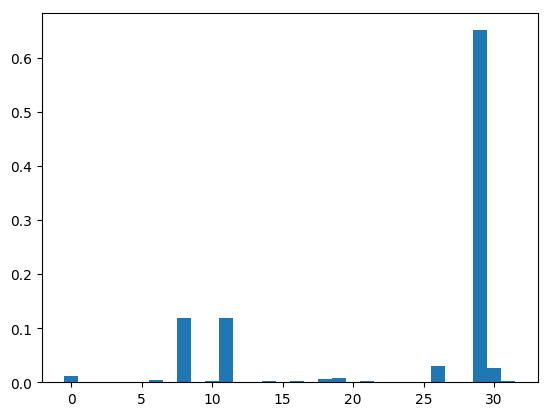

Entropy of distribution: 1.85112207836
[0.012278 0.000167 0.000229 0.000669 0.001273 0.001314 0.004260 0.000055
 0.119591 0.000511 0.001542 0.119096 0.000977 0.000380 0.002635 0.000405
 0.003021 0.000092 0.006769 0.008069 0.000028 0.002082 0.000138 0.001113
 0.000871 0.000748 0.030452 0.000695 0.000578 0.651159 0.025664 0.003140]
Bins:
[0.389365 2.637679 -1.290508 1.630241 1.048134 -0.917485 0.587080 -1.908630
 -0.305280 2.014646 0.956321 0.114459 1.248078 2.274381 0.761564 -1.166865
 -0.787068 -1.627017 0.494955 -0.638086 -2.375600 0.860850 -1.437885
 1.145201 1.356476 1.484588 0.268789 -1.045667 1.804175 -0.098590 -0.477401
 0.672758]


In [29]:
probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
hist = np.sum(probs, axis = 0)
hist /= np.sum(hist)

sample_hist_bins = np.linspace(0, NBINS - 1, NBINS)
plt.bar(sample_hist_bins, hist, align = 'center', width = 1)
plt.show()

entropy = 0
for i in hist:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print "Entropy of distribution:", entropy

print hist
print "Bins:"
print K.eval(QUANT_BINS)

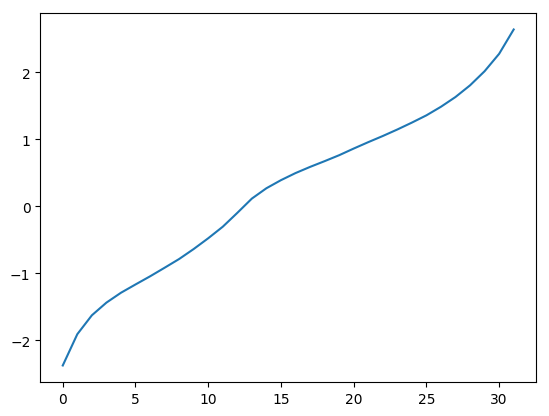

In [30]:
plt.plot(np.sort(np.array(K.eval(QUANT_BINS)).flatten()))
plt.show()

In [31]:
[rate, data] = sciwav.read("./SA1.wav")
data = data.astype(np.float32)
processedWave, wparams = preprocess_waveform(data)
windows = extract_windows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed = np.reshape(windows, (windows.shape[0], WINDOW_SIZE, 1))
embed = encoder.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [32]:
recons = decoder.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [33]:
before_quantization = pre_quant.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)
after_dequantization = post_dequant.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [34]:
K.eval(enc[-1].SOFTMAX_TEMP)

562.63562

In [35]:
max_pct = np.max(embed[25], axis = -1)
print max_pct
print np.argmax(embed[25], axis = -1)
print np.sum(max_pct > 0.98) / float(max_pct.size)

[1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 0.549724
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 0.999998 0.988108 1.000000
 1.000000 1.000000 0.999606 1.000000 1.000000 0.987556 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 0.999999 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 0.999987 1.000000
 1.000000 1.000000 1.000000 0.999945 1.000000 1.000000 1.000000 1.000000
 1.000000 0.847841 1.000000 0.999996 1.000000 1.000000 0.982782 0.955638
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 0.868963 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000

In [36]:
embed_max = np.max(embed, axis = -1)
print np.mean(embed_max)
print np.sum(embed_max > 0.98) / float(embed_max.size)

0.995695
0.976318359375


Original


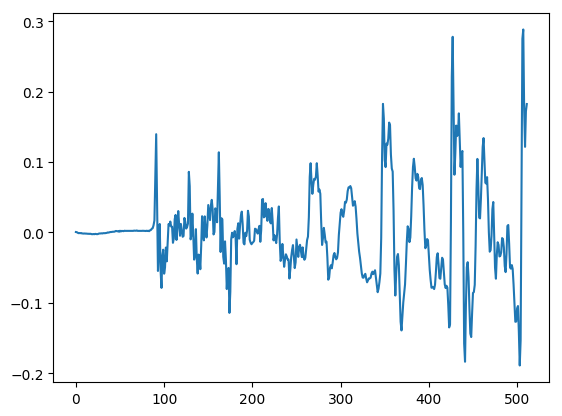

Reconstruction


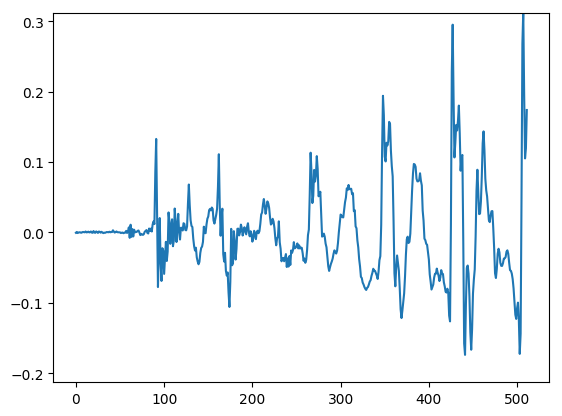

Before quantization


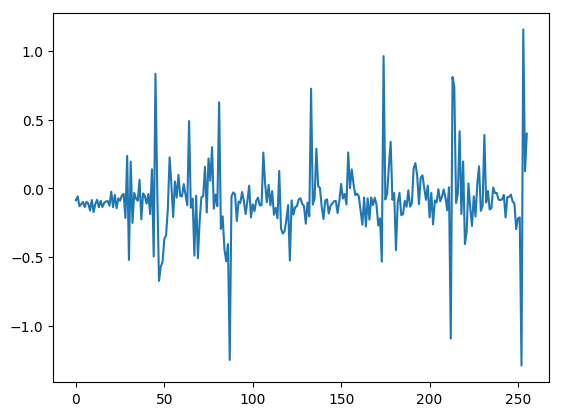

After dequantization


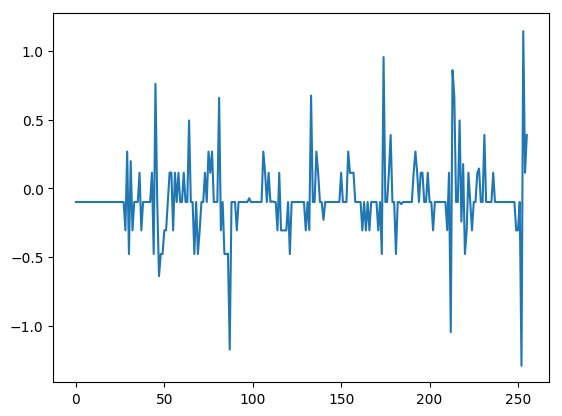

Error


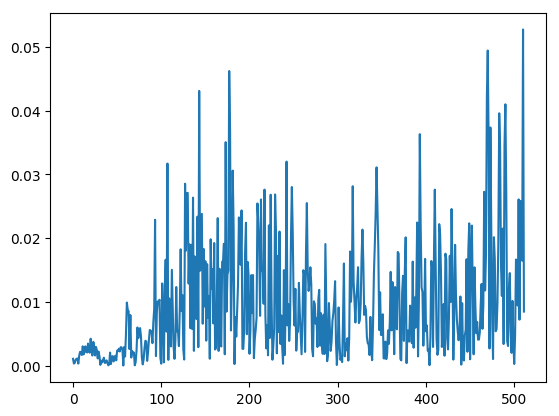

In [37]:
idx = 25
#idx=90

orig = windows[idx].flatten()
recn = recons[idx].flatten()

print "Original"
plt.plot(orig)
ylim = plt.gca().get_ylim()
plt.show()

print "Reconstruction"
plt.plot(recn)
plt.ylim(ylim)
plt.show()

if (K.get_value(QUANTIZATION_ON) > 0):
    print "Before quantization"
    plt.plot(before_quantization[idx])
    ylim = plt.gca().get_ylim()
    plt.show()

    print "After dequantization"
    plt.plot(after_dequantization[idx])
    plt.ylim(ylim)
    plt.show()

'''
print "Code (argmax)"
argmax_code_vec = embed[idx]
embed_sum = np.sum(embed[idx], axis = -1)
argmax_code_vec = np.eye(NBINS)[np.argmax(argmax_code_vec, axis = -1)]
argmax_code_vec[embed_sum < 0.95] = np.zeros(NBINS)
argmax_code_vec = unquantize_vec(argmax_code_vec)
plt.plot(argmax_code_vec)
plt.show()

print "Code (non-argmax)"
na_code_vec = embed[idx]
na_code_vec = unquantize_vec(na_code_vec)
plt.plot(na_code_vec)
plt.show()

print "Difference between argmax and non-argmax"
plt.plot(abs(argmax_code_vec - na_code_vec))
plt.show()
'''
    
print "Error"
plt.plot(abs(orig - recn))
plt.show()